

# Traffic Sign Classification - Prediction Script

This script loads a trained model and predicts traffic signs from images.
Use this file after training the model with train_traffic_sign_model.ipynb




In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.models import load_model

warnings.filterwarnings("ignore")

In [2]:
# Constants
TARGET_SIZE = 32

In [3]:
# Traffic Sign Labels Dictionary
label_name = {
    0: "Speed Limit 20", 1: "Speed Limit 30", 2: "Speed Limit 50", 3: "Speed Limit 60",
    4: "Speed Limit 70", 5: "Speed Limit 80", 6: "End of a Speed Limit 80", 7: "Speed Limit 100",
    8: "Speed Limit 120", 9: "No overtaking", 10: "No overtaking by trucks", 11: "Crossroads",
    12: "Priority Road", 13: "Give way", 14: "Stop", 15: "All vehicles prohibited in both directions",
    16: "No trucks", 17: "No Entry", 18: "Other Hazards", 19: "Curve to left",
    20: "Curve to right", 21: "Double curve, first to the left", 22: "Uneven Road", 23: "Slippery Road",
    24: "Road Narrows Near Side", 25: "Roadworks", 26: "Traffic lights", 27: "No pedestrians",
    28: "Children", 29: "Cycle Route", 30: "Be careful in winter", 31: "Wild animals",
    32: "No parking", 33: "Turn right ahead", 34: "Turn left ahead", 35: "Ahead Only",
    36: "Proceed straight or turn right", 37: "Proceed straight or turn left", 38: "Pass onto right",
    39: "Pass onto left", 40: "Roundabout", 41: "No overtaking", 42: "End of Truck Overtaking Prohibition"
}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load trained model
print("Loading trained model...")
model = load_model("/content/drive/MyDrive/traffic_sign_model.h5")
print("Model loaded successfully!")

Loading trained model...


Model loaded successfully!


In [6]:
# Image preprocessing
def process_single_image(img_array):
    img = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img = tf.image.resize(img_array, [TARGET_SIZE, TARGET_SIZE])
    img = img / 255.0
    img = tf.expand_dims(img, 0)
    return img

In [7]:
# Load from URL
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Error loading image from URL: {e}")
        return None

In [8]:
# Load from local path
def load_image_from_path(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Error loading image from path: {e}")
        return None

In [9]:
# Predict single image
def predict_traffic_sign(model, image_source, source_type='url', show_top_predictions=5):
    if source_type == 'url':
        img_array = load_image_from_url(image_source)
    elif source_type == 'path':
        img_array = load_image_from_path(image_source)
    else:
        print("Invalid source_type. Use 'url' or 'path'")
        return None

    if img_array is None:
        return None

    processed_img = process_single_image(img_array)
    prediction = model.predict(processed_img, verbose=0)
    predicted_class = np.argmax(prediction, axis=-1)[0]
    confidence = np.max(prediction) * 100

    top_indices = np.argsort(prediction[0])[::-1][:show_top_predictions]
    top_predictions = [(i, prediction[0][i] * 100, label_name[i]) for i in top_indices]

    # Display results
    plt.figure(figsize=(15, 8))

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(img_array)
    plt.title('Original Image', fontsize=14, fontweight='bold')
    plt.axis('off')

    # Processed Image
    plt.subplot(2, 2, 2)
    plt.imshow(processed_img[0])
    plt.title(f'Processed ({TARGET_SIZE}x{TARGET_SIZE})', fontsize=14, fontweight='bold')
    plt.axis('off')

    # Main Prediction
    plt.subplot(2, 2, 3)
    plt.text(0.1, 0.9, f'MAIN PREDICTION', fontsize=16, fontweight='bold', transform=plt.gca().transAxes, color='red')
    plt.text(0.1, 0.8, f'Class: {predicted_class}', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'Sign: {label_name[predicted_class]}', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f'Confidence: {confidence:.2f}%', fontsize=14, fontweight='bold', transform=plt.gca().transAxes,
             color='green' if confidence > 80 else 'orange' if confidence > 50 else 'red')

    if confidence > 90:
        confidence_level = "🟢 Very High"
        color = 'green'
    elif confidence > 75:
        confidence_level = "🟡 High"
        color = 'orange'
    elif confidence > 50:
        confidence_level = "🟠 Medium"
        color = 'darkorange'
    else:
        confidence_level = "🔴 Low"
        color = 'red'

    plt.text(0.1, 0.5, f'Accuracy Level: {confidence_level}', fontsize=14, fontweight='bold',
             transform=plt.gca().transAxes, color=color)
    plt.axis('off')

    # Top Predictions
    plt.subplot(2, 2, 4)
    plt.text(0.1, 0.95, f'TOP {show_top_predictions} PREDICTIONS', fontsize=14, fontweight='bold', transform=plt.gca().transAxes, color='blue')
    for i, (class_idx, prob, label) in enumerate(top_predictions):
        y_pos = 0.85 - i * 0.15
        plt.text(0.1, y_pos, f'{i+1}. {label}', fontsize=11, fontweight='bold', transform=plt.gca().transAxes)
        plt.text(0.1, y_pos - 0.05, f'   Confidence: {prob:.2f}%', fontsize=10, transform=plt.gca().transAxes, color='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n")
    print("🚦 TRAFFIC SIGN PREDICTION RESULTS")

    print(f" Image Source: {image_source}")
    print(f" Predicted Class: {predicted_class}")
    print(f" Traffic Sign: {label_name[predicted_class]}")
    print(f" Confidence: {confidence:.2f}%")
    print(f" Accuracy Level: {confidence_level}")
    print("\n Top Predictions:")
    for i, (class_idx, prob, label) in enumerate(top_predictions):
        print(f"   {i+1}. {label}: {prob:.2f}%")
    print("="*60)

    return {
        'predicted_class': predicted_class,
        'predicted_label': label_name[predicted_class],
        'confidence': confidence,
        'confidence_level': confidence_level,
        'top_predictions': top_predictions,
        'all_predictions': prediction[0]
    }

In [10]:
print("\n Model is ready for predictions!")
print("Use the following examples to predict traffic signs:")


 Model is ready for predictions!
Use the following examples to predict traffic signs:


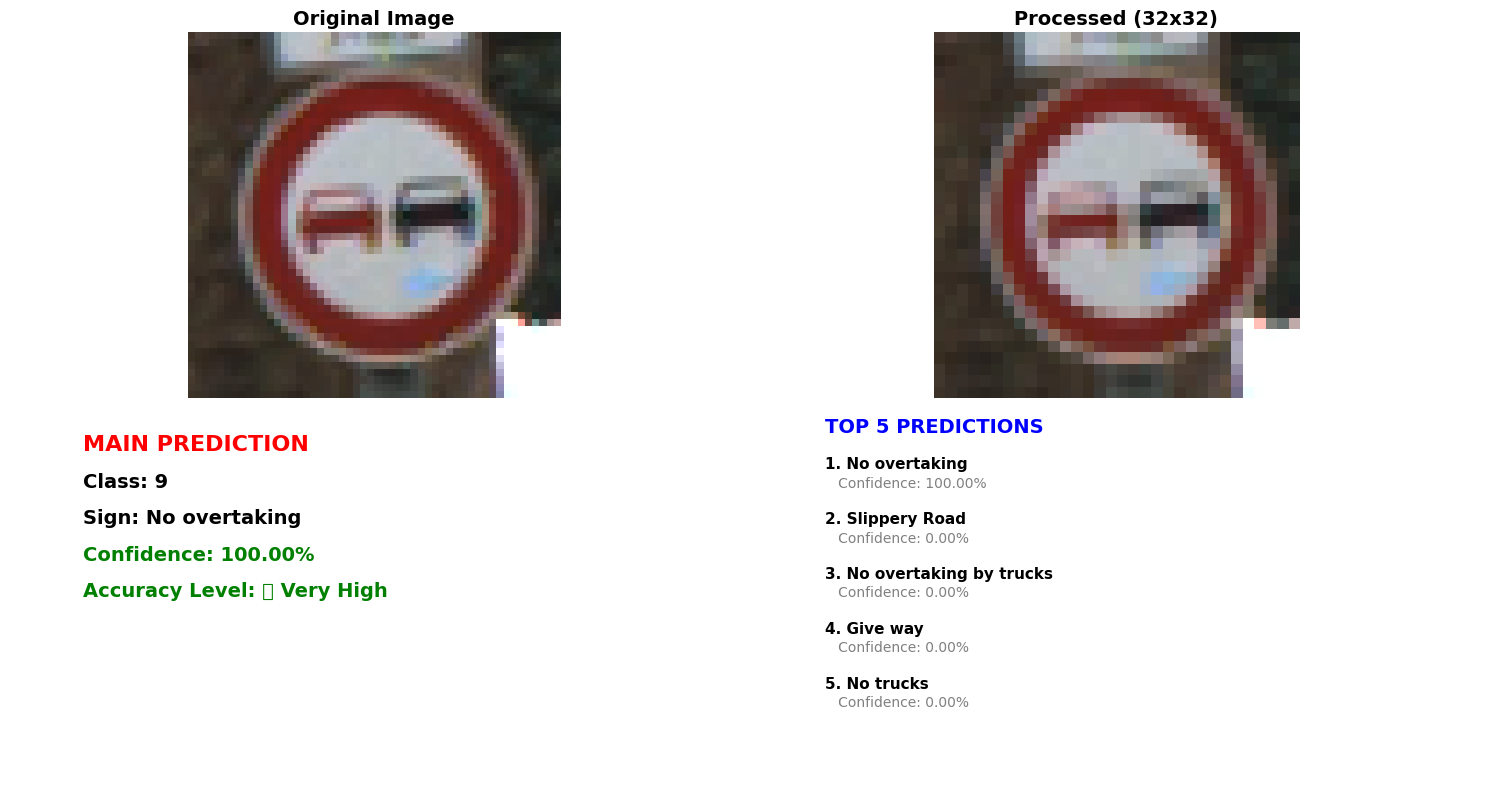



🚦 TRAFFIC SIGN PREDICTION RESULTS
 Image Source: /content/drive/MyDrive/00065.png
 Predicted Class: 9
 Traffic Sign: No overtaking
 Confidence: 100.00%
 Accuracy Level: 🟢 Very High

 Top Predictions:
   1. No overtaking: 100.00%
   2. Slippery Road: 0.00%
   3. No overtaking by trucks: 0.00%
   4. Give way: 0.00%
   5. No trucks: 0.00%


In [11]:
# Test a single image from a local path
result = predict_traffic_sign(model, "/content/drive/MyDrive/00065.png", 'path')

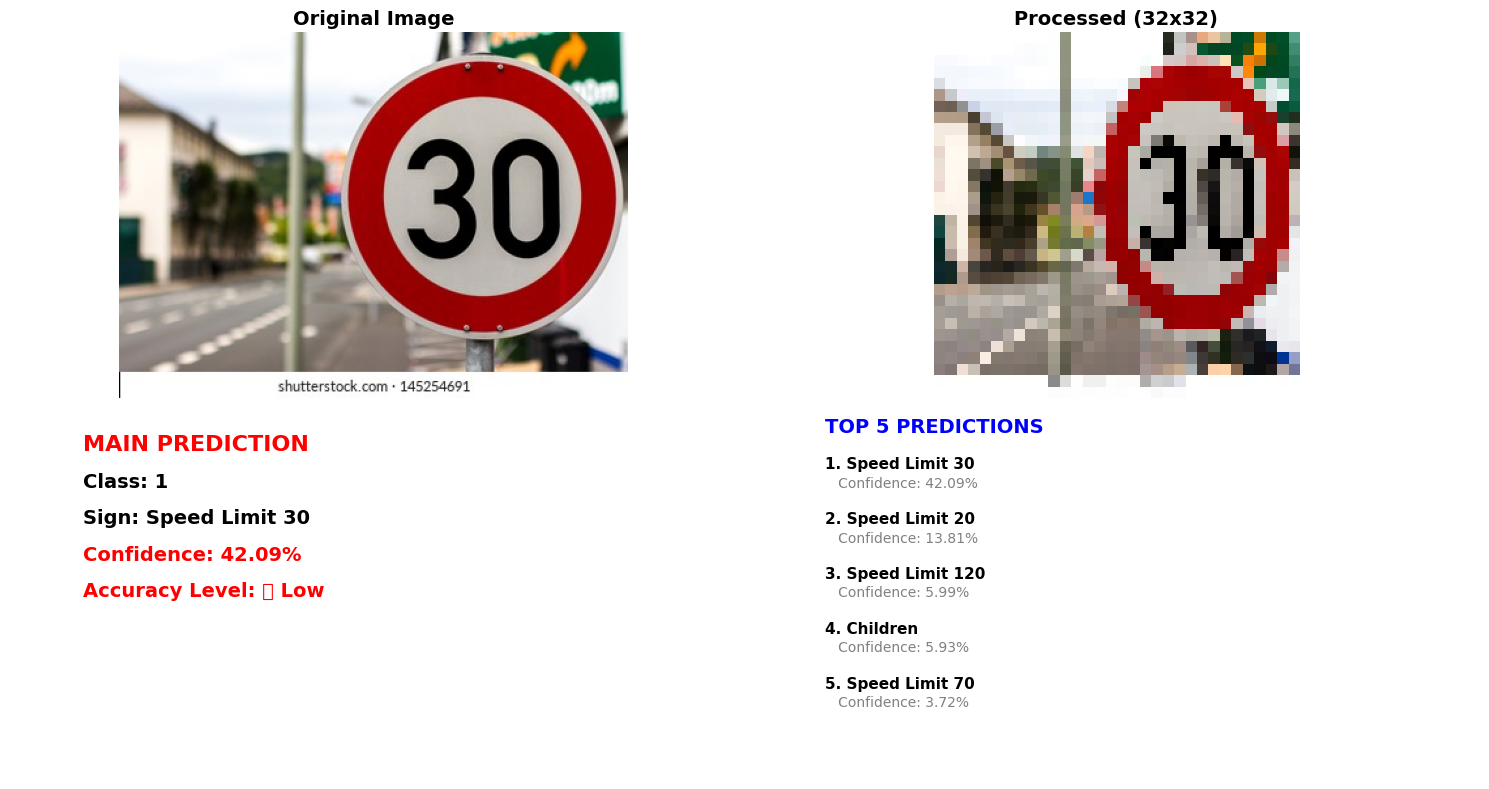



🚦 TRAFFIC SIGN PREDICTION RESULTS
 Image Source: https://www.shutterstock.com/image-photo/german-30-speed-sign-260nw-145254691.jpg
 Predicted Class: 1
 Traffic Sign: Speed Limit 30
 Confidence: 42.09%
 Accuracy Level: 🔴 Low

 Top Predictions:
   1. Speed Limit 30: 42.09%
   2. Speed Limit 20: 13.81%
   3. Speed Limit 120: 5.99%
   4. Children: 5.93%
   5. Speed Limit 70: 3.72%


In [12]:
# Test a single image from a url path
result = predict_traffic_sign(model, 'https://www.shutterstock.com/image-photo/german-30-speed-sign-260nw-145254691.jpg', 'url')